# Modelling the growth of the Delta Variant in the UK

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import requests
import pandas as pd
import numpy as np
from requests import get
from json import dumps
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
plt.style.use('ggplot')

## Import data from Sanger COVID-19 Dashboard
Pivot by index: date, columns: lineage, values: count

In [2]:
sang =  pd.read_csv('https://covid-surveillance-data.cog.sanger.ac.uk/download/lineages_by_ltla_and_week.tsv',delimiter='\t')
sang['WeekEndDate'] = pd.to_datetime(sang['WeekEndDate']).dt.date
spiv = sang.pivot_table(index='WeekEndDate',columns='Lineage',values='Count')
spiv.head()

Lineage,A,A.18,A.2.5.1,A.20,A.23,A.23.1,A.25,A.27,A.28,AV.1,...,C.6,G.1,H.1,I.1,Lineage data suppressed,M.1,None,P.1,P.2,R.1
WeekEndDate,,,,,,,,,,,,,,,,,,,,,
2020-09-05,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,2.016129,NaN,1.0,NaN,NaN,NaN
2020-09-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,1.250000,NaN,NaN,NaN,NaN,NaN
2020-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.305085,NaN,NaN,NaN,NaN,NaN
2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,1.500000,NaN,1.0,NaN,NaN,NaN
2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.081081,NaN,NaN,NaN,NaN,NaN


Get proportions from absolute sequence counts

In [3]:
spiv['tot'] = spiv.sum(axis=1)
spiv['relB.1.1.7']  = spiv['B.1.1.7']/spiv['tot']
spiv['relB.1.617.2']  = spiv['B.1.617.2']/spiv['tot']
spiv = spiv.fillna(0)

## Fetch case data from gov dashboard api

In [4]:
gov = pd.read_csv('https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv')
gov.rename(columns={'newCasesBySpecimenDate':'newCases'},inplace=True)
gov['date'] = pd.to_datetime(gov['date']).dt.date

In [5]:
gov.head()

,areaCode,areaName,areaType,date,newCases
0,K02000001,United Kingdom,overview,2021-07-19,11813
1,K02000001,United Kingdom,overview,2021-07-18,30834
2,K02000001,United Kingdom,overview,2021-07-17,35260
3,K02000001,United Kingdom,overview,2021-07-16,51626
4,K02000001,United Kingdom,overview,2021-07-15,60031


## DataFrame for plotting
Merge Sanger's sequence data with case counts

In [6]:
dfplot = gov.groupby('date').agg({'newCases':'sum'}).reset_index()
dfplot = dfplot[dfplot['date'] > dt.date(2021,3,1)]

In [7]:
dfplot = dfplot.merge(spiv[['relB.1.1.7','relB.1.617.2']],left_on='date',right_index=True,how='left')

In [8]:
#for col in ['relB.1.1.7','relB.1.617.2']:
#    dfplot[col+'_interpol'] = dfplot[col].interpolate(method='linear')

# i. From all data to current situation
## Exploratory: Plot case data & delta proportion of sequences

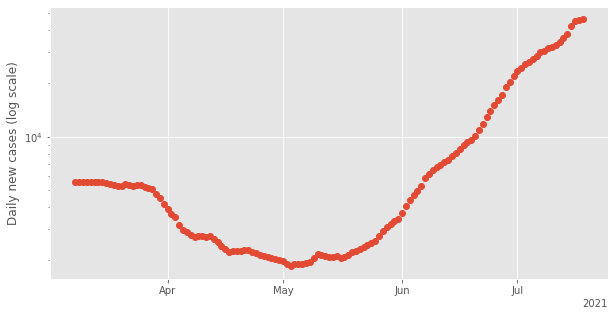

In [9]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

datem = mdates.date2num(dfplot['date'])[:-1]

# axvlines below on bank holidays
#ax.axvline(mdates.date2num(dt.date(2021,5,3)),c='#999999')
#ax.axvline(mdates.date2num(dt.date(2021,5,31)),c='#999999')

ax.plot(datem,dfplot['newCases'][:-1].rolling(7).mean(),marker='o',linestyle='')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Daily new cases (log scale)")

plt.yscale('log')

plt.show()

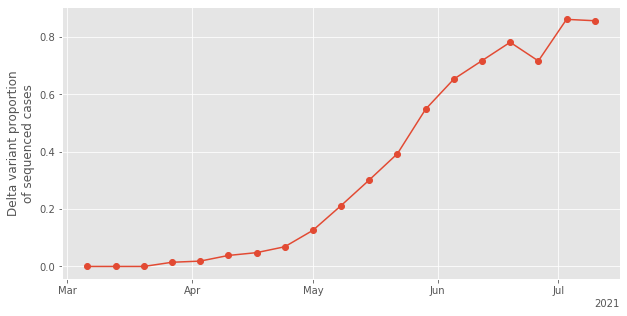

In [10]:
fig = plt.figure(figsize=(10,5))
ax=plt.axes()

dfplotb = dfplot.dropna(subset=['relB.1.617.2'])
x = mdates.date2num(dfplotb['date'])
y = dfplotb['relB.1.617.2']

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Delta variant proportion\nof sequenced cases")

plt.plot(x,y,marker='o')
plt.show()

## Model proportion of delta sequences with sigmoid curve

In [11]:
from scipy.optimize import curve_fit

In [12]:
# assumes overall proportion of Delta approaches 1

def sigmoid(x, x0, k, b):
    y = 1 / (1+ np.exp(-k*(x-x0)))+b
    return (y)

p0 = [np.median(x),0.06,min(y)]

popt,pcov = curve_fit(sigmoid,x,y,p0)

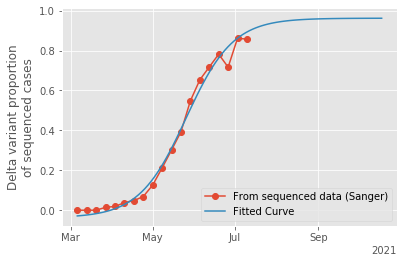

In [13]:
ax = plt.axes()
plt.plot(x,y,marker='o',label="From sequenced data (Sanger)")
xs = np.linspace(min(x),max(x)+100,100)
ys = np.array([sigmoid(xv,*popt) for xv in xs])

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Delta variant proportion\nof sequenced cases")

plt.plot(xs,ys,label="Fitted Curve")
plt.legend()

plt.show()

## Apply modelled delta proportion to overall case data

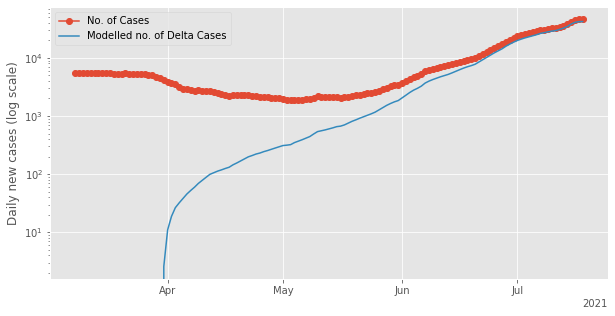

In [14]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

datem = mdates.date2num(dfplot['date'])[:-1]
rel617 = np.array([sigmoid(k,*popt) for k in datem])

ax.plot(datem,dfplot['newCases'][:-1].rolling(7).mean(),marker='o',label="No. of Cases")

modelled_y = dfplot['newCases'][:-1].rolling(7).mean()*rel617
ax.plot(datem, modelled_y, label="Modelled no. of Delta Cases")

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Daily new cases (log scale)")

plt.yscale('log')
plt.legend()
plt.show()

## Fit exponential curve to modelled Delta case counts

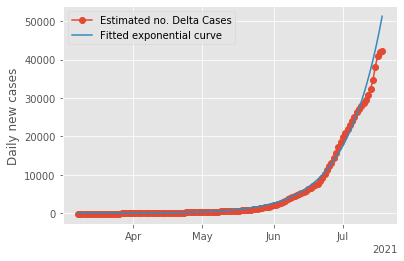

In [15]:
def expon(x,x0,b,k):
    y = b * np.exp(k*(x-x0))
    return y

p0 = [737857,10000,1]

epopt,epcov = curve_fit(expon,datem[6:-7],modelled_y[6:-7],p0)

ax = plt.axes()
plt.plot(datem[6:],modelled_y[6:],marker='o',label="Estimated no. Delta Cases")
xsb = np.linspace(datem[6],datem[-1],100)
ysb = np.array([expon(xv,*epopt) for xv in xsb])

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.plot(xsb,ysb,label="Fitted exponential curve")

plt.legend()
ax.set_ylabel("Daily new cases")

plt.show()

## 

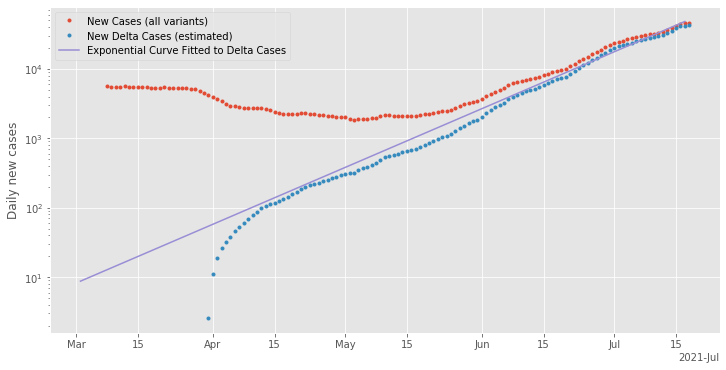

In [16]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

datem = mdates.date2num(dfplot['date'])[:-1]
rel617 = np.array([sigmoid(k,*popt) for k in datem])

ax.plot(datem,dfplot['newCases'][:-1].rolling(7).mean(),marker='o',markersize=3,linestyle='',label="New Cases (all variants)")

modelled_y = dfplot['newCases'][:-1].rolling(7).mean()*rel617
ax.plot(datem,modelled_y,linestyle='',marker='o',markersize=3,label="New Delta Cases (estimated)")
#ax.plot(datem,dfplot['newCases'][:-1].rolling(7).mean()-modelled_y,linestyle='',marker='o',markersize=3,label="estimated non-delta")

extended_datem = np.arange(datem[0],datem[-1],1)
expon_fit_y = np.array([expon(k,*epopt) for k in extended_datem])
ax.plot(extended_datem,expon_fit_y,label="Exponential Curve Fitted to Delta Cases")

#ax.plot(extended_datem,expon_fit_y+1600, label="modelled total")


locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Daily new cases")

plt.legend()
plt.yscale('log')

plt.show()

# ii. Modelled Growth of Delta from early Data Only 

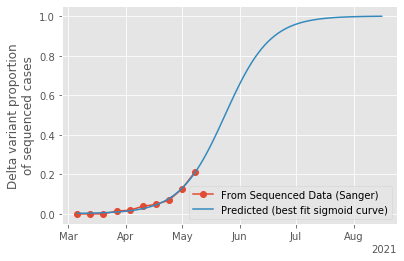

In [17]:
# Fitting sigmoid curve to early Data (to early May when estimated ~20% of cases were the Delta variant)
# assumes overall proportion of Delta approaches 1

def sigmoid(x, x0, k, b):
    y = 1 / (1+ np.exp(-k*(x-x0)))+b
    return (y)

x_apr = mdates.date2num(dfplotb[dfplotb['date'] < dt.date(2021,5,10)]['date'])
y_apr = dfplotb[dfplotb['date'] < dt.date(2021,5,10)]['relB.1.617.2']

p0 = [np.median(x_apr),0.06,min(y_apr)]

popt,pcov = curve_fit(sigmoid,x_apr,y_apr,p0)

ax = plt.axes()
plt.plot(x_apr,y_apr,marker='o',label="From Sequenced Data (Sanger)")
xs = np.linspace(min(x_apr),max(x_apr)+100,100)
ys = np.array([sigmoid(xv,*popt) for xv in xs])

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Delta variant proportion\nof sequenced cases")

plt.plot(xs,ys,label="Predicted (best fit sigmoid curve)")
plt.legend()

plt.show()

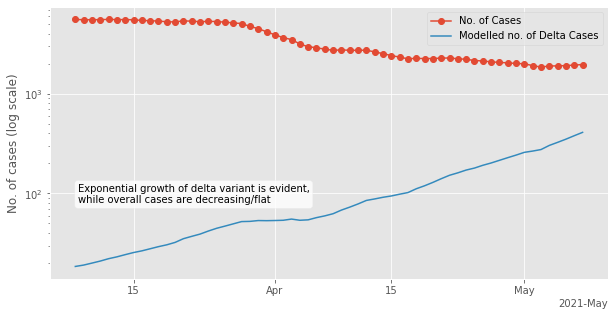

In [18]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

datem = mdates.date2num(dfplot[dfplot['date'] < dt.date(2021,5,10)]['date'])[:-1]
rel617 = np.array([sigmoid(k,*popt) for k in datem])

ax.plot(datem,dfplot[dfplot['date'] < dt.date(2021,5,10)]['newCases'][:-1].rolling(7).mean(),marker='o',label="No. of Cases")

modelled_y = dfplot[dfplot['date'] < dt.date(2021,5,10)]['newCases'][:-1].rolling(7).mean()*rel617
ax.plot(datem, modelled_y, label="Modelled no. of Delta Cases")

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel("No. of cases (log scale)")

ax.text(0.05, 0.35, "Exponential growth of delta variant is evident,\nwhile overall cases are decreasing/flat", transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox={'boxstyle':'round','facecolor':'#ffffff','alpha':0.8})
plt.yscale('log')
plt.legend()
plt.show()

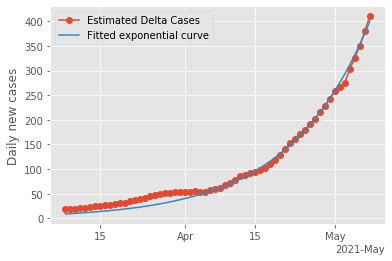

In [19]:
def expon(x,x0,b,k):
    y = b * np.exp(k*(x-x0))
    return y

p0 = [737857,10000,1]

epopt,epcov = curve_fit(expon,datem[40:-7],modelled_y[40:-7],p0)

ax = plt.axes()
plt.plot(datem[6:],modelled_y[6:],marker='o',label="Estimated Delta Cases")
xsb = np.linspace(datem[6],datem[-1],100)
ysb = np.array([expon(xv,*epopt) for xv in xsb])

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Daily new cases")

plt.plot(xsb,ysb,label="Fitted exponential curve")

plt.legend()
plt.show()

In [20]:
# estimated growth rate
est_gr = (epopt[2]+1)**7
print(f"Predicted 7-day growth rate of {round(est_gr,2)}")

Predicted 7-day growth rate of 1.52


For total cases, without accounting for proportions of variants, the actual recorded 7-day growth rate was far lower. Once Delta became the prevalent strain, 

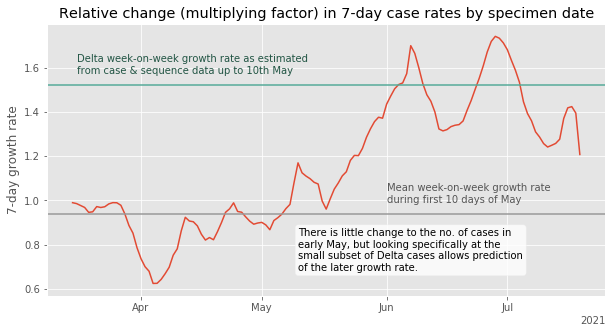

In [21]:
# plot 7-day % change in new cases
dfplot['7DayChange'] = dfplot['newCases'].astype(float).rolling(14).apply(lambda x: np.sum(x[7:])/np.sum(x[:7]))

fig = plt.figure(figsize=(10,5))
ax = plt.axes()

#ax.axvline(mdates.date2num(dt.date(2021,5,10)),color="#999999")
ax.plot(mdates.date2num(dfplot['date']),dfplot['7DayChange'])

ax.axhline(est_gr,c="#55AA99")
ax.text(mdates.date2num(min(dfplot['date']))+14,est_gr+0.05,"Delta week-on-week growth rate as estimated\nfrom case & sequence data up to 10th May",c="#225544")

emay_gr = dfplot[((dfplot['date'] < dt.date(2021,5,10)) & (dfplot['date'] > dt.date(2021,4,30)))]['7DayChange'].mean()
ax.axhline(emay_gr,c="#999999")
ax.text(mdates.date2num(dt.date(2021,6,1)),emay_gr+0.05,"Mean week-on-week growth rate\nduring first 10 days of May",c="#555555")

ax.text(0.45, 0.25, "There is little change to the no. of cases in\nearly May, but looking specifically at the\nsmall subset of Delta cases allows prediction\nof the later growth rate.", transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox={'boxstyle':'round','facecolor':'#ffffff','alpha':0.8})

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("7-day growth rate")
ax.set_title('Relative change (multiplying factor) in 7-day case rates by specimen date')

plt.show()

A case growth projection based on the data up to 10th May when the Delta variant made up only ~20% of cases shows that, thanks to the incredible sequencing coverage in the UK, the exponential case growth in late May onwards was predictable at a time when the overall cases were flat.

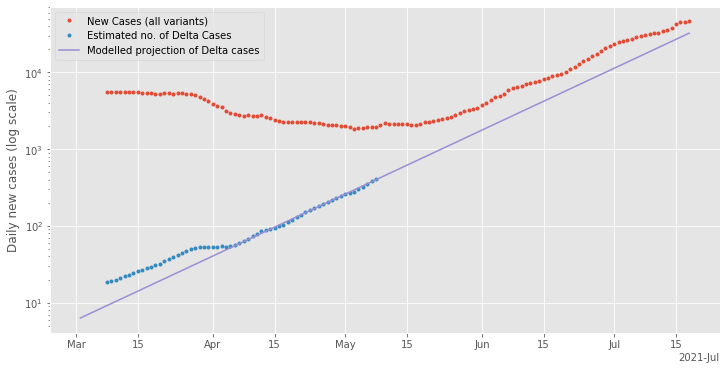

In [22]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

#datem = mdates.date2num(dfplot['date'])[:-1]
datem_to_now = mdates.date2num(dfplot['date'])[:-1]
rel617 = np.array([sigmoid(k,*popt) for k in datem])

ax.plot(datem_to_now,dfplot['newCases'][:-1].rolling(7).mean(),marker='o',markersize=3,linestyle='',label="New Cases (all variants)")

modelled_y = dfplot[dfplot['date'] < dt.date(2021,5,10)]['newCases'][:-1].rolling(7).mean()*rel617
ax.plot(datem,modelled_y,linestyle='',marker='o',markersize=3,label="Estimated no. of Delta Cases")
#ax.plot(datem,dfplot['newCases'][:-1].rolling(7).mean()-modelled_y,linestyle='',marker='o',markersize=3,label="estimated non-delta")

expon_fit_y = np.array([expon(k,*epopt) for k in datem_to_now])
ax.plot(datem_to_now,expon_fit_y,label="Modelled projection of Delta cases")

#ax.plot(extended_datem,expon_fit_y+1600, label="modelled total")


locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel("Daily new cases (log scale)")


plt.legend()
plt.yscale('log')

plt.show()